## 인물 모드 문제점 찾기

In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

my_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
my_img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image1.jpg'
my_img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image2.jpg'
my_img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image3.jpg'
my_img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image4.jpg'
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.jpg'


## 클래스 정의

In [2]:
class CameraModeApp:
    def __init__(self):
        self.model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
        self.model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출)
        self.class_names = [
            'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
            'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
            'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
        ]
        self.class_colors = self.init_colormap()

        
        
    #컬러맵 만들기
    def init_colormap(self):
        colormap = np.zeros((256, 3), dtype = int)
        ind = np.arange(256, dtype=int)

        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        return colormap
        
        
    def apply_shallow_focus(self, img_path, focus_classes=['person'], blur_kernel=(30,30)):
        #원본 이미지 
        img_orig = cv2.imread(img_path) 
        
        # pacalvoc 데이터로 학습된 모델을 이용 이미지를 분할, 분할 출력의 배열을 가져옴
        segvalues, output = self.model.segmentAsPascalvoc(img_path)
        
        seg_map = np.zeros(output.shape[:2], dtype=np.uint8)

        for cls in focus_classes:
            if cls in self.class_names:
                class_idx = self.class_names.index(cls)
                color = self.class_colors[class_idx]
                bgr_color = (color[2], color[1], color[0])
                seg_map |= np.all(output == bgr_color, axis=-1)
            else:
                print(f"'{cls}' not defined in Pascal VOC")
        
        
        # True과 False인 값을 각각 255과 0으로 바꿔줍니다
        img_mask = seg_map.astype(np.uint8) * 255
        
        img_orig_blur = cv2.blur(img_orig, blur_kernel)
        
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        
        # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
        # 연산을 하고 나면 배경은 255 사람은 0입니다.
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        
        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
        
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
        
        return img_orig, img_concat
    
    
    def apply_background_chromakey(self, img_path, bg_path, focus_classes=['person']):
        #원본 이미지 
        img_orig = cv2.imread(img_path)
        bg = cv2.imread(bg_path)
        
        # 배경과 이미지 크기가 다른 경우 resize
        if bg.shape[:2] != img_orig.shape[:2]:
            bg = cv2.resize(bg, (img_orig.shape[1], img_orig.shape[0]))
        
        # pacalvoc 데이터로 학습된 모델을 이용 이미지를 분할, 분할 출력의 배열을 가져옴
        segvalues, output = self.model.segmentAsPascalvoc(img_path)
        
        seg_map = np.zeros(output.shape[:2], dtype=np.uint8)

        for cls in focus_classes:
            if cls in self.class_names:
                class_idx = self.class_names.index(cls)
                color = self.class_colors[class_idx]
                bgr_color = (color[2], color[1], color[0])
                seg_map |= np.all(output == bgr_color, axis=-1)
            else:
                print(f"'{cls}' not defined in Pascal VOC")
        
        
        # True과 False인 값을 각각 255과 0으로 바꿔줍니다
        img_mask = seg_map.astype(np.uint8) * 255
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        

        img_concat = np.where(img_mask_color==255, img_orig, bg)
        
        return img_orig, img_concat
    


## 예제 사진

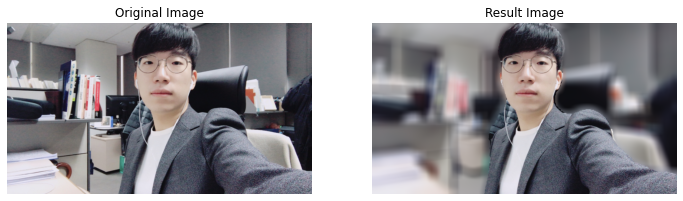

In [3]:
app = CameraModeApp()
img_orig, img_result = app.apply_shallow_focus(my_img_path)

plt.figure(figsize=(16, 9))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 결과 이미지
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## 인물 사진

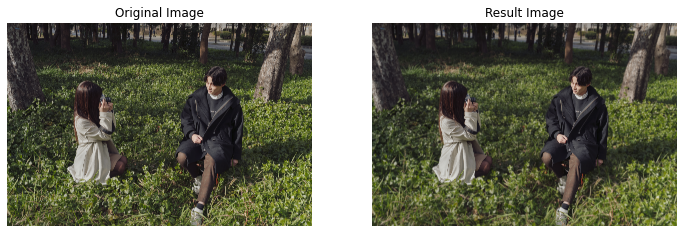

In [4]:
img_show = app.apply_shallow_focus(my_img_path1)
img_orig, img_result = app.apply_shallow_focus(my_img_path1)

plt.figure(figsize=(16, 9))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 결과 이미지
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## 고양이 사진

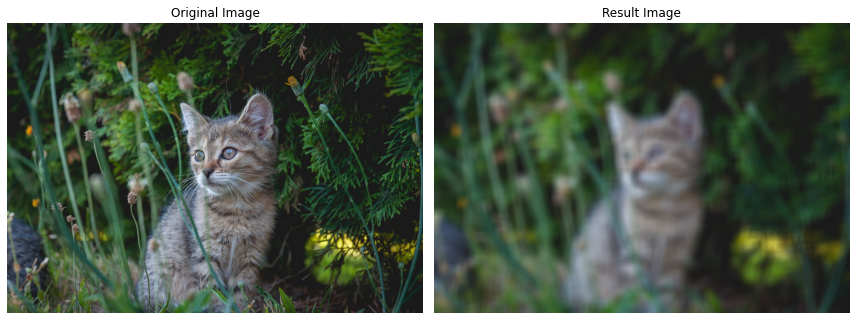

In [5]:
img_show = app.apply_shallow_focus(my_img_path2,['cat'])
img_orig, img_result = app.apply_shallow_focus(my_img_path2)

plt.figure(figsize=(16, 9))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 결과 이미지
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## 배경 크로마키

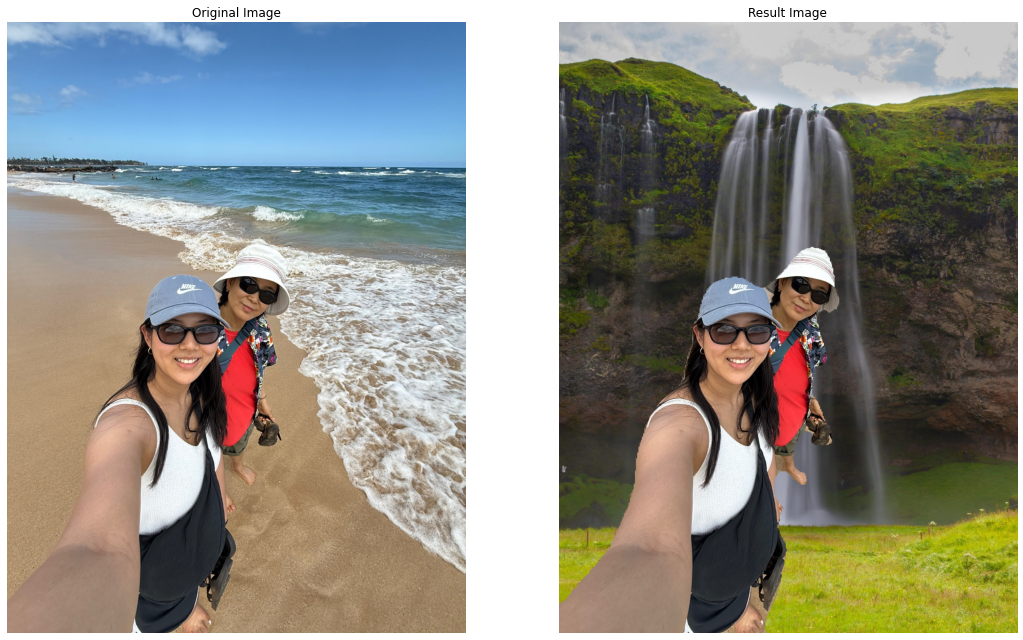

In [7]:

img_orig, img_result = app.apply_background_chromakey(my_img_path3, bg_path)

plt.figure(figsize=(16, 9))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 결과 이미지
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## 문제 파악 및 해결책 찾기

### 경계선이 명확하지 않다. 잘못된 물체를 인식하거나 인식해야될 부분을 인식하지 못한다 
-> 좀 더 정밀한 모델로 변경을 시도해 볼 수 있다( HRNet, SegFormer 등 )
 - 예제 이미지의 경우 경계가 잘못 인식된다. 어깨 부분의 회색이 블러처리되고 패딩아래를 보면 배경이그대로 나오는 부분도 있다.
 - 인물사진1의 경우 문제점 파악이 쉽지 않았다 그래서 명확한 대비색과 경계가 있으면 처리가 잘되는 것 같다는 생각이다.
 - 고양이 사진의 경우 고양이와 배경이 섞여있어 그런지 고양이 자체를 인식하지 못했다. 모델의 인식 성능이 떨어진다고 판단된다.
 - 크로마키처리 사진의 경우 앞 인물의 등에 있는 머리카락을 배경처리한 것으로 보인다. 그리고 모자 윗 부분들이 어색하게 잘려나갔다.


### 속도가 실사용할 수 없는 수준이었다.
-> 좀 더 경량화된 모델과 처리 기법을 찾아본다 ( DeepLabV3+, ONNX + OpenCV DNN 등 )   
-> 이미지 해상도 축소 후 처리한 후 원래 결과로 출력하는 방법을 고려해 볼 수 있다.   
-> np.all 은 처리 속도가 느리다고 한다. ( opencv 자체 처리 함수를 고려하거나 다른 method를 사용한다 )

### 크로마키 이미지의 경우 사람이 공중에 떠있는 것을 볼 수 있다
-> 배경에 대해서도 학습을 통해 지면과 공중을 분리해 볼 수 있다.   
-> 아니라면 배경에 대해서는 리사이즈와 위치 이동에 대한 권한을 사용자에게 주어 원하는 위치로 조정할 수 있게 하는 방법이 있다.





## 회고 
문제점 파악 후 해결한 코드작성까지 해보고싶었지만 그정도로 해볼 수 있는 실력은 안되는 것 같다. 과제의 핵심보다 너무 코드 작성과 소프트웨어적인 부분에 치우치고 있는게 아닌가 반성했다. 시간 분배를 잘해야겠다는 생각이 들었다. 해결책을 찾아보면서 다른 모델들을 찾아보고 이해해보려 했지만 이해가 쉽지 않았다. 아직 공부해야 될 것이 많다는 것을 느낀다. 그래도 이것 저것 찾아보면서 많은 모델들을 새롭게 접해 볼 수 있어 좋았다.